In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import cv2 
import glob 
import numpy as np 
import matplotlib.pyplot as plt 
import re 

IMG_SIZE = 28
path = 'arrow_images/*.jpg'
images = []
labels = []

print("Starting image processing...")

for file in glob.glob(path):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Could not read image {file}. Skipping.")
        continue

    match = re.search(r'([01]{4})', file)
    if match:
        label_str = match.group(1)
        label_vec = [int(bit) for bit in label_str]

        # Convert one-hot vector to a class index 
        class_index = label_vec.index(1) 
        labels.append(class_index)

        resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(resized_img)
    else:
        print(f"Warning: Could not find a 4-digit label in filename {file}. Skipping.")

images = np.array(images, dtype=np.float32) / 255.0 
labels = np.array(labels)
inputs = torch.from_numpy(images) 

# Create a LongTensor for the labels 
targets = torch.from_numpy(labels).long() 

dataset = TensorDataset(inputs, targets)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# --- Verification ---
print(f"\nProcessing complete.")
print(f"Loaded {len(images)} images.")
print(f"Shape of inputs tensor: {inputs.shape}")
print(f"Shape of targets tensor: {targets.shape}") 

Starting image processing...

Processing complete.
Loaded 11 images.
Shape of inputs tensor: torch.Size([11, 28, 28])
Shape of targets tensor: torch.Size([11])


In [ ]:
# Define the Neural Network Architecture 
class ArrowClassifier(nn.Module):
    def __init__(self):
        super(ArrowClassifier, self).__init__()
        self.fc1 = nn.Linear(IMG_SIZE * IMG_SIZE, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = x.view(-1, IMG_SIZE * IMG_SIZE)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the model, define the loss function and optimizer
model = ArrowClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Model 
epochs = 150
print("\nStarting training...")

for epoch in range(epochs):
    for batch_inputs, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("\nTraining finished.")

# Save the trained model's weights for the final demo
torch.save(model.state_dict(), 'arrow_model.pth')
print("Model saved to arrow_model.pth. Ready for the final step!")


Starting training...
Epoch [10/150], Loss: 0.8682
Epoch [20/150], Loss: 0.3734
Epoch [30/150], Loss: 0.0680
Epoch [40/150], Loss: 0.0162
Epoch [50/150], Loss: 0.0124
Epoch [60/150], Loss: 0.0051
Epoch [70/150], Loss: 0.0026
Epoch [80/150], Loss: 0.0032
Epoch [90/150], Loss: 0.0016
Epoch [100/150], Loss: 0.0017
Epoch [110/150], Loss: 0.0010
Epoch [120/150], Loss: 0.0007
Epoch [130/150], Loss: 0.0008
Epoch [140/150], Loss: 0.0007
Epoch [150/150], Loss: 0.0007

Training finished.
Model saved to arrow_model.pth. Ready for the final step!



--- CHECKPOINT 3 DEMO ---
Model prediction for 'test_arrow.jpg': **Right**


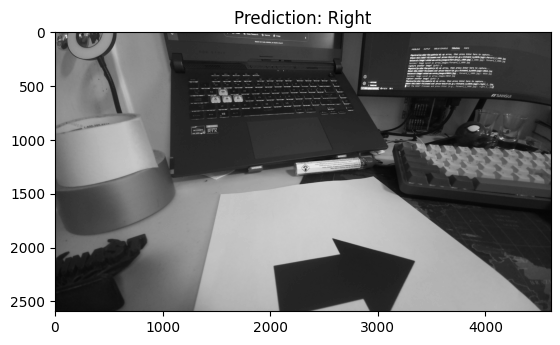

In [ ]:
inference_model = ArrowClassifier()
inference_model.load_state_dict(torch.load('arrow_model.pth'))
inference_model.eval()

# Load and Process the New Test Image 
test_image_path = 'test_arrow.jpg'
test_img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

if test_img is not None:
    resized_test_img = cv2.resize(test_img, (IMG_SIZE, IMG_SIZE))
    img_tensor = torch.from_numpy(resized_test_img.astype(np.float32) / 255.0)

    # Making a prediction by using torch.no_grad() to speed up inference and save memory
    with torch.no_grad():
        output = inference_model(img_tensor)
        # Find the index of the highest score, which is our prediction
        _, predicted_index = torch.max(output, 1)
    
    # Interpret and Display the Result 
    # Create a mapping from index number to direction string
    directions = {0: 'Forward', 1: 'Left', 2: 'Right', 3: 'Backward'}
    predicted_direction = directions[predicted_index.item()]
    
    print(f"\n--- CHECKPOINT 3 DEMO ---")
    print(f"Model prediction for '{test_image_path}': **{predicted_direction}**")
    
    # Display the test image with its predicted label
    plt.imshow(test_img, cmap='gray')
    plt.title(f"Prediction: {predicted_direction}")
    plt.show()

else:
    print(f"Error: Could not load the test image. Make sure 'test_arrow.jpg' is in your 'project' folder.")